In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import kerastuner as kt

In [11]:
train_dir = './files/TumorClassification/train'
test_dir = './files/TumorClassification/test'

train_datage = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = train_datage.flow_from_directory(
    train_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset = 'training'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(124, 124),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 1050 images belonging to 3 classes.
Found 28 images belonging to 3 classes.
Found 144 images belonging to 3 classes.


In [13]:
classes = ["BENIGN", "MALIGNANT", "NORMAL"]

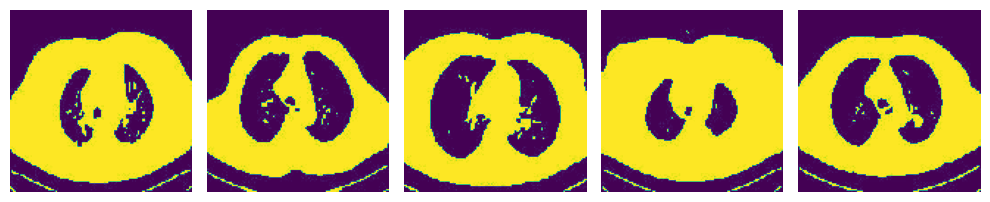

In [14]:
def plotImages(img_arr):
    fig, axes = plt.subplots(1,5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [15]:
def vis_result(hist, e=20):
    epochs = [i for i in range(e)]
    fig, ax = plt.subplots(1,2)
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

In [ ]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(75, (3,3), activation='relu', input_shape=(124, 124, 1))),
    model.add(tf.keras.layers.MaxPooling2D(2, 2)),
    model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(1e-5), activation='relu')),
    model.add(tf.keras.layers.Dropout(0.2)),
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    return model

hypermodel = get_model()
hypermodel.summary()

hypermodel.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 75)   │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 279075)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │   142,886,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,953,713 (545.33 MB)

 Trainable params: 142,953,713 (545.33 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpoint_path = "./models/checkpoint.weights.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch',
                             save_weights_only = False,
                             monitor = "val_accuracy",
                             save_best_only = True,
                             verbose = 1
                             )

In [ ]:
hist_hp = hypermodel.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint])

Epoch 1/10
8/9 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3725 - loss: 118.6960